In [1]:
#Covariance 3x2 + cluster version 1 - Dec 1st 2019
# NxN, NxCls (gg, gk, kk) 
# Incorporates Photo-z uncertainties and mass-richness relationship
# mass integral taken outside (assuming average redshift within bin)
# units now checked 
# Limber assuming for C-ells (l)
# using 2FAST algorithm to tackle double bessel integrals 
# using approximation formula from Assassi, Simonovic and Zaldarriaga paper to overcome Hypergeometric function of a complex argument
# assuming full sky for now
# Included Gaussian plus SSC
# Added full matrix in the end 

# *****************************************************************

#import necessary modules for our computation
import numpy as np
import time
from scipy.integrate import romb, quad  #this will be necessary for some integrals
from scipy.special import gamma #this will import spherical bessel functions, gamma and Gauss Hypergeometric function
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pyccl as ccl #import CCL python wrapper 

In [2]:
#Setup initial cosmology and Make a ccl class. We will later vary them for MCMC
Omg_c = 0.26
Omg_b = 0.04
h0 = 0.67 #so H0 = 100h0 will be in km/s/Mpc
A_s_value = 2.1e-9
n_s_value = 0.96
w_0 = -1.
w_a = 0.0
overdensity_delta = 200
c = 299792.458 # in km/s

survey_area = 4*np.pi #assuming full sky for now

cosmo = ccl.Cosmology(Omega_c = Omg_c, 
                      Omega_b = Omg_b, 
                      h = h0, 
                      A_s = A_s_value, 
                      n_s = n_s_value, 
                      w0 = w_0, wa = w_a)

In [3]:
#Define arrays for bins for Photometric z and Z grid
Zmin = 0.3
Zmax = 1.2
Z_bin_range = 0.05
Num_z_bins = round((Zmax-Zmin)/Z_bin_range)
Z_bins = np.round(np.linspace(Zmin,Zmax,Num_z_bins+1),2)
print(Z_bins, Num_z_bins)
print("Minimum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[0])))+ " Mpc")
print("Maximum radial distance is " + str(ccl.comoving_radial_distance(cosmo, 1/(1+Z_bins[Num_z_bins])))+ " Mpc")

[0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95
 1.   1.05 1.1  1.15 1.2 ] 18
Minimum radial distance is 1247.8400578373084 Mpc
Maximum radial distance is 3931.479845283442 Mpc


In [5]:
# insert function that calculates Photo z, given true redshift z_true and photometric bin z_i
def photoz(z_true, z_i): 
    sigma_z = 0.05*(1+z_true)
    integrand = lambda z_phot: np.exp(- (z_phot - z_true)**2. / (2.*sigma_z**2.))/ (np.sqrt(2.*np.pi) * sigma_z)
    return (quad(integrand,Z_bins[z_i], Z_bins[z_i+1])[0]/(1.-quad(integrand, -np.inf, 0.)[0]))
# Notice that I am truncating the pdf, so as to absorb the negative redshifts into the positive part of the pdf

Lim_z_min = max(0.02, Z_bins[0]-4*Z_bin_range) #minimum z_true for the integrals. I am assuming z_true>0.02 
Lim_z_max = Z_bins[-1]+6*Z_bin_range #maximum z_true for the integrals, assuming 40% larger than max z, so we dont need to go till infinity

Lim_R_min = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_min))
Lim_R_max = ccl.comoving_radial_distance(cosmo, 1/(1+Lim_z_max))

print(Lim_z_min, Lim_R_min)
print(Lim_z_max, Lim_R_max)

0.09999999999999998 437.18704239759813
1.5 4558.602004298992


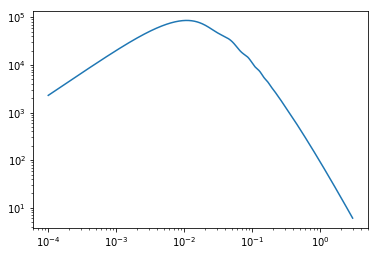

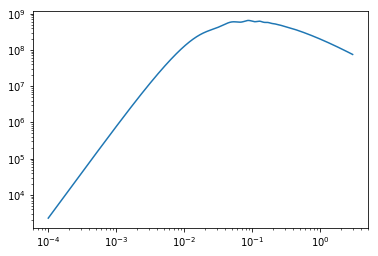

2293.8187696736672 74686413.61445285
[1.00000000e-04 1.01012812e-04 1.02035883e-04 ... 2.94014216e+00
 2.96992028e+00 3.00000000e+00]


In [6]:
# Prepare r array and k array for 2-FAST
#Define main parameters
ko = 1.e-4
kmax = 3
ro = 1/kmax
rmax = 1/ko
G = np.log(kmax/ko)
N = 1024
L = 2*np.pi*N/G
k_vec = np.logspace(np.log(ko), np.log(kmax), N, base = np.exp(1))
r_vec = np.logspace(np.log(ro), np.log(rmax), N, base = np.exp(1))
bias_fft = 1.4165
pk_vec = ccl.linear_matter_power(cosmo, k_vec, 1)
fk_vec = (k_vec/ko)**(3.-bias_fft)*pk_vec # this is the function to be fftlog-ed 
plt.loglog(k_vec, pk_vec)
plt.show()
plt.loglog(k_vec, fk_vec)
plt.show()
print(fk_vec[0], fk_vec[-1])
print(k_vec)

In [7]:
# Performing the FFT of the fk_vec function, leveraging the fact it is real
Phi_vec = np.conjugate(np.fft.rfft(fk_vec))/L

In [8]:
#Calculating the function M_0_0
def I_ell (m, R): #the formula below only valid for R <=1, l = 0,  formula B2 ASZ and 31 from 2-fast paper 
    t_m = 2*np.pi*m/G
    alpha_m = bias_fft-1.j*t_m
    pre_factor =(ko*ro)**(-alpha_m)
    if R<1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*(1/R)*((1+R)**(2-alpha_m)-(1-R)**(2-alpha_m))
    elif R==1:
        return pre_factor*0.5*np.cos(np.pi*alpha_m/2)*gamma(alpha_m-2)*((1+R)**(2-alpha_m))
    

In [9]:
#this range includes the Min and  Max limits of the integrals, with a +- safety factor of 5
Index_min = np.int(np.argwhere(r_vec>Lim_R_min)[0]-5)
Index_max = np.int(np.argwhere(r_vec<Lim_R_max)[-1]+5)
print(Index_min,Index_max)

708 950


In [10]:
# function that calculates the double bessel integral from I-ell algorithm, as function of z1 and z2
def double_bessel_integral (z1,z2):
    r2 = ccl.comoving_radial_distance(cosmo, 1/(1+z2))
    r1 = ccl.comoving_radial_distance(cosmo, 1/(1+z1))
    R = min(r1, r2)/max(r1, r2) #definition of t, forcing it to be <= 1
    I_ell_vec = [I_ell(m,R) for m in range(N//2+1)]
    back_FFT_vec = np.fft.irfft(Phi_vec*I_ell_vec)*N # FFT back
    two_fast_vec = (1/np.pi)*(ko**3)*((r_vec/ro)**(-bias_fft))*back_FFT_vec/G
    f = interp1d(r_vec[Index_min:Index_max],two_fast_vec[Index_min:Index_max], kind = 'cubic') #we will use this to interpolate the exact r(z1)
    return f(max(r1, r2))
    


In [10]:
# Now we define photo-Z adjusted dNdZ 

def dNdZ_true (z, alpha=1.24, beta=1.01, z0=0.51):
    """Smail et al. 1994 redshift dist"""
    return np.power(z, alpha) * np.exp(-np.power(z/z0, beta))
nz = 128
z_true_vec = np.linspace(Lim_z_min, Lim_z_max,nz)
z_true_vec_inverse = z_true_vec[::-1]
scale_factor_vec = 1/(1+z_true_vec_inverse)

#Normalized dNdZ array as a function of z_true per photo-z bin
dNdZ_photo_bin = np.zeros((Num_z_bins,nz))
for z_i in range (Num_z_bins):
    denom = lambda x: dNdZ_true(x)*photoz(x, z_i)
    dNdZ_photo_bin[z_i] = [dNdZ_true(z_true_vec[i])*photoz(z_true_vec[i],z_i)/quad(denom, Lim_z_min, Lim_z_max)[0] for i in range (nz)]

print(dNdZ_photo_bin)
print(z_true_vec_inverse)
print(scale_factor_vec)

[[1.01695566e-03 2.69493869e-03 6.61026776e-03 ... 5.64313104e-19
  3.56784288e-19 2.25932769e-19]
 [1.88631564e-05 6.39747023e-05 1.98999838e-04 ... 1.97489280e-17
  1.25293902e-17 7.96007505e-18]
 [1.60620062e-07 7.09196870e-07 2.84432271e-06 ... 6.01090584e-16
  3.83214516e-16 2.44596203e-16]
 ...
 [2.86030540e-66 1.78649730e-63 8.55756904e-61 ... 1.15882537e-02
  8.94714266e-03 6.88496607e-03]
 [2.84736009e-73 2.92114950e-70 2.26115978e-67 ... 4.08083332e-02
  3.22904832e-02 2.54534202e-02]
 [1.24888525e-80 2.13927009e-77 2.71878989e-74 ... 1.22899252e-01
  9.98024474e-02 8.06986151e-02]]
[1.5        1.48897638 1.47795276 1.46692913 1.45590551 1.44488189
 1.43385827 1.42283465 1.41181102 1.4007874  1.38976378 1.37874016
 1.36771654 1.35669291 1.34566929 1.33464567 1.32362205 1.31259843
 1.3015748  1.29055118 1.27952756 1.26850394 1.25748031 1.24645669
 1.23543307 1.22440945 1.21338583 1.2023622  1.19133858 1.18031496
 1.16929134 1.15826772 1.14724409 1.13622047 1.12519685 1.1141732

In [11]:
# Pre-calculate sigma square for the Z_true ranges we have
sigma_square_vec = np.zeros((nz, nz))
for z1 in range(nz):
    for z2 in range(z1,nz):
        sigma_square_vec[z1,z2] = double_bessel_integral(z_true_vec_inverse[z1], z_true_vec_inverse[z2])
        sigma_square_vec[z2,z1] = sigma_square_vec[z1,z2]
        print(z1,z2)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1

12 67
12 68
12 69
12 70
12 71
12 72
12 73
12 74
12 75
12 76
12 77
12 78
12 79
12 80
12 81
12 82
12 83
12 84
12 85
12 86
12 87
12 88
12 89
12 90
12 91
12 92
12 93
12 94
12 95
12 96
12 97
12 98
12 99
12 100
12 101
12 102
12 103
12 104
12 105
12 106
12 107
12 108
12 109
12 110
12 111
12 112
12 113
12 114
12 115
12 116
12 117
12 118
12 119
12 120
12 121
12 122
12 123
12 124
12 125
12 126
12 127
13 13
13 14
13 15
13 16
13 17
13 18
13 19
13 20
13 21
13 22
13 23
13 24
13 25
13 26
13 27
13 28
13 29
13 30
13 31
13 32
13 33
13 34
13 35
13 36
13 37
13 38
13 39
13 40
13 41
13 42
13 43
13 44
13 45
13 46
13 47
13 48
13 49
13 50
13 51
13 52
13 53
13 54
13 55
13 56
13 57
13 58
13 59
13 60
13 61
13 62
13 63
13 64
13 65
13 66
13 67
13 68
13 69
13 70
13 71
13 72
13 73
13 74
13 75
13 76
13 77
13 78
13 79
13 80
13 81
13 82
13 83
13 84
13 85
13 86
13 87
13 88
13 89
13 90
13 91
13 92
13 93
13 94
13 95
13 96
13 97
13 98
13 99
13 100
13 101
13 102
13 103
13 104
13 105
13 106
13 107
13 108
13 109
13 110
13 111


24 79
24 80
24 81
24 82
24 83
24 84
24 85
24 86
24 87
24 88
24 89
24 90
24 91
24 92
24 93
24 94
24 95
24 96
24 97
24 98
24 99
24 100
24 101
24 102
24 103
24 104
24 105
24 106
24 107
24 108
24 109
24 110
24 111
24 112
24 113
24 114
24 115
24 116
24 117
24 118
24 119
24 120
24 121
24 122
24 123
24 124
24 125
24 126
24 127
25 25
25 26
25 27
25 28
25 29
25 30
25 31
25 32
25 33
25 34
25 35
25 36
25 37
25 38
25 39
25 40
25 41
25 42
25 43
25 44
25 45
25 46
25 47
25 48
25 49
25 50
25 51
25 52
25 53
25 54
25 55
25 56
25 57
25 58
25 59
25 60
25 61
25 62
25 63
25 64
25 65
25 66
25 67
25 68
25 69
25 70
25 71
25 72
25 73
25 74
25 75
25 76
25 77
25 78
25 79
25 80
25 81
25 82
25 83
25 84
25 85
25 86
25 87
25 88
25 89
25 90
25 91
25 92
25 93
25 94
25 95
25 96
25 97
25 98
25 99
25 100
25 101
25 102
25 103
25 104
25 105
25 106
25 107
25 108
25 109
25 110
25 111
25 112
25 113
25 114
25 115
25 116
25 117
25 118
25 119
25 120
25 121
25 122
25 123
25 124
25 125
25 126
25 127
26 26
26 27
26 28
26 29
26 30
26

37 124
37 125
37 126
37 127
38 38
38 39
38 40
38 41
38 42
38 43
38 44
38 45
38 46
38 47
38 48
38 49
38 50
38 51
38 52
38 53
38 54
38 55
38 56
38 57
38 58
38 59
38 60
38 61
38 62
38 63
38 64
38 65
38 66
38 67
38 68
38 69
38 70
38 71
38 72
38 73
38 74
38 75
38 76
38 77
38 78
38 79
38 80
38 81
38 82
38 83
38 84
38 85
38 86
38 87
38 88
38 89
38 90
38 91
38 92
38 93
38 94
38 95
38 96
38 97
38 98
38 99
38 100
38 101
38 102
38 103
38 104
38 105
38 106
38 107
38 108
38 109
38 110
38 111
38 112
38 113
38 114
38 115
38 116
38 117
38 118
38 119
38 120
38 121
38 122
38 123
38 124
38 125
38 126
38 127
39 39
39 40
39 41
39 42
39 43
39 44
39 45
39 46
39 47
39 48
39 49
39 50
39 51
39 52
39 53
39 54
39 55
39 56
39 57
39 58
39 59
39 60
39 61
39 62
39 63
39 64
39 65
39 66
39 67
39 68
39 69
39 70
39 71
39 72
39 73
39 74
39 75
39 76
39 77
39 78
39 79
39 80
39 81
39 82
39 83
39 84
39 85
39 86
39 87
39 88
39 89
39 90
39 91
39 92
39 93
39 94
39 95
39 96
39 97
39 98
39 99
39 100
39 101
39 102
39 103
39 104
39 

53 111
53 112
53 113
53 114
53 115
53 116
53 117
53 118
53 119
53 120
53 121
53 122
53 123
53 124
53 125
53 126
53 127
54 54
54 55
54 56
54 57
54 58
54 59
54 60
54 61
54 62
54 63
54 64
54 65
54 66
54 67
54 68
54 69
54 70
54 71
54 72
54 73
54 74
54 75
54 76
54 77
54 78
54 79
54 80
54 81
54 82
54 83
54 84
54 85
54 86
54 87
54 88
54 89
54 90
54 91
54 92
54 93
54 94
54 95
54 96
54 97
54 98
54 99
54 100
54 101
54 102
54 103
54 104
54 105
54 106
54 107
54 108
54 109
54 110
54 111
54 112
54 113
54 114
54 115
54 116
54 117
54 118
54 119
54 120
54 121
54 122
54 123
54 124
54 125
54 126
54 127
55 55
55 56
55 57
55 58
55 59
55 60
55 61
55 62
55 63
55 64
55 65
55 66
55 67
55 68
55 69
55 70
55 71
55 72
55 73
55 74
55 75
55 76
55 77
55 78
55 79
55 80
55 81
55 82
55 83
55 84
55 85
55 86
55 87
55 88
55 89
55 90
55 91
55 92
55 93
55 94
55 95
55 96
55 97
55 98
55 99
55 100
55 101
55 102
55 103
55 104
55 105
55 106
55 107
55 108
55 109
55 110
55 111
55 112
55 113
55 114
55 115
55 116
55 117
55 118
55 119

73 108
73 109
73 110
73 111
73 112
73 113
73 114
73 115
73 116
73 117
73 118
73 119
73 120
73 121
73 122
73 123
73 124
73 125
73 126
73 127
74 74
74 75
74 76
74 77
74 78
74 79
74 80
74 81
74 82
74 83
74 84
74 85
74 86
74 87
74 88
74 89
74 90
74 91
74 92
74 93
74 94
74 95
74 96
74 97
74 98
74 99
74 100
74 101
74 102
74 103
74 104
74 105
74 106
74 107
74 108
74 109
74 110
74 111
74 112
74 113
74 114
74 115
74 116
74 117
74 118
74 119
74 120
74 121
74 122
74 123
74 124
74 125
74 126
74 127
75 75
75 76
75 77
75 78
75 79
75 80
75 81
75 82
75 83
75 84
75 85
75 86
75 87
75 88
75 89
75 90
75 91
75 92
75 93
75 94
75 95
75 96
75 97
75 98
75 99
75 100
75 101
75 102
75 103
75 104
75 105
75 106
75 107
75 108
75 109
75 110
75 111
75 112
75 113
75 114
75 115
75 116
75 117
75 118
75 119
75 120
75 121
75 122
75 123
75 124
75 125
75 126
75 127
76 76
76 77
76 78
76 79
76 80
76 81
76 82
76 83
76 84
76 85
76 86
76 87
76 88
76 89
76 90
76 91
76 92
76 93
76 94
76 95
76 96
76 97
76 98
76 99
76 100
76 101
76 1

104 107
104 108
104 109
104 110
104 111
104 112
104 113
104 114
104 115
104 116
104 117
104 118
104 119
104 120
104 121
104 122
104 123
104 124
104 125
104 126
104 127
105 105
105 106
105 107
105 108
105 109
105 110
105 111
105 112
105 113
105 114
105 115
105 116
105 117
105 118
105 119
105 120
105 121
105 122
105 123
105 124
105 125
105 126
105 127
106 106
106 107
106 108
106 109
106 110
106 111
106 112
106 113
106 114
106 115
106 116
106 117
106 118
106 119
106 120
106 121
106 122
106 123
106 124
106 125
106 126
106 127
107 107
107 108
107 109
107 110
107 111
107 112
107 113
107 114
107 115
107 116
107 117
107 118
107 119
107 120
107 121
107 122
107 123
107 124
107 125
107 126
107 127
108 108
108 109
108 110
108 111
108 112
108 113
108 114
108 115
108 116
108 117
108 118
108 119
108 120
108 121
108 122
108 123
108 124
108 125
108 126
108 127
109 109
109 110
109 111
109 112
109 113
109 114
109 115
109 116
109 117
109 118
109 119
109 120
109 121
109 122
109 123
109 124
109 125
109 126


In [12]:
#Define standard CCL tracers for position and shear
bg = 1.3*np.ones(nz) #Assuming constant linear bias for now

Gal_position = np.array([ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_true_vec, dNdZ_photo_bin[z_i]), bias=(z_true_vec, bg)) for z_i in range (Num_z_bins)])
Gal_shear = np.array([ccl.WeakLensingTracer(cosmo, dndz=(z_true_vec, dNdZ_photo_bin[z_i])) for z_i in range(Num_z_bins)])


print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],100), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 100), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],100))
print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],400), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 400), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],400))
print(ccl.angular_cl(cosmo, Gal_position[1],Gal_position[1],1000), ccl.angular_cl(cosmo, Gal_position[1], Gal_shear[1], 1000), ccl.angular_cl(cosmo, Gal_shear[1], Gal_shear[1],1000))

1.100786189310137e-05 2.910014941832694e-08 1.1637647585841946e-09
1.690147901399684e-06 4.622929026494401e-09 2.3277542778984884e-10
6.245005807618647e-07 1.7495429133226779e-09 7.236840826004956e-11


6.176240640297431e-07
1.30132862337123e-06
(128, 1024)


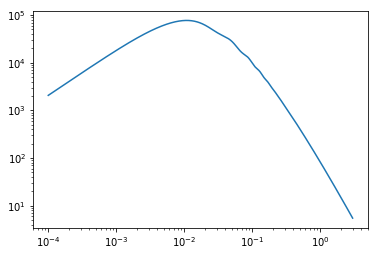

In [13]:
#Create customized power spectrum


lpk_array = np.array([ccl.linear_matter_power(cosmo,k_vec,a) for a in scale_factor_vec])
Growth_vector = np.array([ccl.growth_factor(cosmo, a) for a in scale_factor_vec])
# TestingPk2D object for ell = 500
pk_original = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_array, is_logp=False)
print(ccl.angular_cl(cosmo, Gal_position[1], Gal_position[1], 500, p_of_k_a=pk_original))
print(ccl.angular_cl(cosmo, Gal_position[1], Gal_position[1],500))
plt.loglog(k_vec, lpk_array[-1])
print(lpk_array.shape)

In [36]:
# Define partial integral for first Cl times sigma square
n_ell = 3
ell_vec = np.linspace(200,1200,n_ell)
def partial_gg (i, z_a,z_b):
    lpk_aux = np.transpose(np.transpose(lpk_array)*Growth_vector*68/21*sigma_square_vec[i])#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_position[z_a], Gal_position[z_b], ell_vec, p_of_k_a=pk_adjusted)
def partial_gk (i, z_a,z_b):
    lpk_aux = np.transpose(np.transpose(lpk_array)*Growth_vector*68/21*sigma_square_vec[i])#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_position[z_a], Gal_shear[z_b], ell_vec, p_of_k_a=pk_adjusted)
def partial_kk (i, z_a,z_b):
    lpk_aux = np.transpose(np.transpose(lpk_array)*Growth_vector*68/21*sigma_square_vec[i])#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_shear[z_a], Gal_shear[z_b], ell_vec, p_of_k_a=pk_adjusted)

print(partial_gg(2,3,5), partial_gk(30,6,8), partial_kk(100,8,7))


[2.61585206e-11 2.40412902e-12 7.31562532e-13] [2.40286637e-13 2.28452414e-14 7.04034452e-15] [1.85719808e-14 1.39489064e-15 3.84740297e-16]


In [37]:
partial_vec_gg = np.zeros((Num_z_bins, Num_z_bins,nz, n_ell))
partial_vec_kk = np.zeros((Num_z_bins, Num_z_bins,nz, n_ell))
for z_a in range(Num_z_bins):
    for z_b in range(z_a, Num_z_bins):
        print("gg interaction " + str(z_a) + " and " + str(z_b))
        partial_vec_gg[z_a,z_b] = [partial_gg(i,z_a,z_b) for i in range(nz)]
        partial_vec_gg[z_b,z_a] = partial_vec_gg[z_a,z_b]
        print("kk interaction " + str(z_a) + " and " + str(z_b))
        partial_vec_kk[z_a,z_b] = [partial_kk(i,z_a,z_b) for i in range(nz)]
        partial_vec_kk[z_b,z_a] = partial_vec_kk[z_a,z_b]
        

        

gg interaction 0 and 0
kk interaction 0 and 0
gg interaction 0 and 1
kk interaction 0 and 1
gg interaction 0 and 2
kk interaction 0 and 2
gg interaction 0 and 3
kk interaction 0 and 3
gg interaction 0 and 4
kk interaction 0 and 4
gg interaction 0 and 5
kk interaction 0 and 5
gg interaction 0 and 6
kk interaction 0 and 6
gg interaction 0 and 7
kk interaction 0 and 7
gg interaction 0 and 8
kk interaction 0 and 8
gg interaction 0 and 9
kk interaction 0 and 9
gg interaction 0 and 10
kk interaction 0 and 10
gg interaction 0 and 11
kk interaction 0 and 11
gg interaction 0 and 12
kk interaction 0 and 12
gg interaction 0 and 13
kk interaction 0 and 13
gg interaction 0 and 14
kk interaction 0 and 14
gg interaction 0 and 15
kk interaction 0 and 15
gg interaction 0 and 16
kk interaction 0 and 16
gg interaction 0 and 17
kk interaction 0 and 17
gg interaction 1 and 1
kk interaction 1 and 1
gg interaction 1 and 2
kk interaction 1 and 2
gg interaction 1 and 3
kk interaction 1 and 3
gg interaction 1 a

In [38]:
partial_vec_gk = np.zeros((Num_z_bins, Num_z_bins,nz, n_ell))
for z_a in range (Num_z_bins):
    for z_b in range(Num_z_bins):
        print("gk interaction " + str(z_a) + " and " + str(z_b))
        partial_vec_gk[z_a,z_b] = [partial_gk(i,z_a,z_b) for i in range(nz)]

gk interaction 0 and 0
gk interaction 0 and 1
gk interaction 0 and 2
gk interaction 0 and 3
gk interaction 0 and 4
gk interaction 0 and 5
gk interaction 0 and 6
gk interaction 0 and 7
gk interaction 0 and 8
gk interaction 0 and 9
gk interaction 0 and 10
gk interaction 0 and 11
gk interaction 0 and 12
gk interaction 0 and 13
gk interaction 0 and 14
gk interaction 0 and 15
gk interaction 0 and 16
gk interaction 0 and 17
gk interaction 1 and 0
gk interaction 1 and 1
gk interaction 1 and 2
gk interaction 1 and 3
gk interaction 1 and 4
gk interaction 1 and 5
gk interaction 1 and 6
gk interaction 1 and 7
gk interaction 1 and 8
gk interaction 1 and 9
gk interaction 1 and 10
gk interaction 1 and 11
gk interaction 1 and 12
gk interaction 1 and 13
gk interaction 1 and 14
gk interaction 1 and 15
gk interaction 1 and 16
gk interaction 1 and 17
gk interaction 2 and 0
gk interaction 2 and 1
gk interaction 2 and 2
gk interaction 2 and 3
gk interaction 2 and 4
gk interaction 2 and 5
gk interaction 2 a

In [39]:
print(partial_vec_gg[3,7,:,2])

[2.27226582e-13 2.27237182e-13 2.27247430e-13 2.27257295e-13
 2.27266766e-13 2.27275821e-13 2.27284438e-13 2.27292590e-13
 2.27300244e-13 2.27307365e-13 2.27313909e-13 2.27319836e-13
 2.27325139e-13 2.27329757e-13 2.27333634e-13 2.27336816e-13
 2.27339146e-13 2.27340525e-13 2.27341089e-13 2.27340676e-13
 2.27338805e-13 2.27336145e-13 2.27332124e-13 2.27326608e-13
 2.27319987e-13 2.27311836e-13 2.27301771e-13 2.27290067e-13
 2.27276540e-13 2.27260806e-13 2.27242805e-13 2.27222555e-13
 2.27199452e-13 2.27173392e-13 2.27144437e-13 2.27112065e-13
 2.27075798e-13 2.27035490e-13 2.26990977e-13 2.26941230e-13
 2.26886261e-13 2.26825435e-13 2.26757849e-13 2.26683081e-13
 2.26600179e-13 2.26508067e-13 2.26406115e-13 2.26292714e-13
 2.26166349e-13 2.26025938e-13 2.25869016e-13 2.25693391e-13
 2.25496459e-13 2.25274902e-13 2.25025150e-13 2.24742277e-13
 2.24421528e-13 2.24056459e-13 2.23639484e-13 2.23163883e-13
 2.22621010e-13 2.22016154e-13 2.21338352e-13 2.20567640e-13
 2.19715087e-13 2.187924

In [40]:
#finally calculating the covariances 3x2 


def COV_Cl_gg_Cl_gg (z_a, z_b, l_ab, z_c, z_d, l_cd, G):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_gg[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    if (l_ab == l_cd) and (z_a == z_c) and (z_b == z_d) and (G==True):
        gaussian_gg = 2.*(ccl.angular_cl(cosmo, Gal_position[z_a], Gal_position[z_b],ell_vec[l_ab])**2)/(2.*ell_vec[l_ab]+1)
    else:
        gaussian_gg = 0.
    return ccl.angular_cl(cosmo, Gal_position[z_c], Gal_position[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted) + gaussian_gg

def COV_Cl_gk_Cl_gg (z_a, z_b, l_ab, z_c, z_d,l_cd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_gk[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_position[z_c], Gal_position[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted)

def COV_Cl_kk_Cl_gg (z_a, z_b, l_ab, z_c, z_d,l_cd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_kk[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_position[z_c], Gal_position[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted)

def COV_Cl_gk_Cl_gk (z_a, z_b, l_ab, z_c, z_d, l_cd, G):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_gk[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    if (l_ab == l_cd) and (z_a == z_c) and (z_b == z_d) and (G==True):
        gaussian_gk = 2.*(ccl.angular_cl(cosmo, Gal_position[z_a], Gal_shear[z_b],ell_vec[l_ab])**2)/(2.*ell_vec[l_ab]+1)
    else:
        gaussian_gk = 0.
    return ccl.angular_cl(cosmo, Gal_position[z_c], Gal_shear[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted) + gaussian_gk

def COV_Cl_kk_Cl_gk (z_a, z_b, l_ab, z_c, z_d,l_cd):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_kk[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    return ccl.angular_cl(cosmo, Gal_position[z_c], Gal_shear[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted)

def COV_Cl_kk_Cl_kk (z_a, z_b, l_ab, z_c, z_d, l_cd,G):
    lpk_aux = np.transpose(np.transpose(lpk_array)*partial_vec_kk[z_a,z_b,:,l_ab]*Growth_vector*68/21)#I am creating a synthetic Pk blending the sigma square function into Pk, so as to use ccl C-ell routines 
    pk_adjusted = ccl.Pk2D(a_arr=scale_factor_vec, lk_arr=np.log(k_vec), pk_arr=lpk_aux, is_logp=False)
    if (l_ab == l_cd) and (z_a == z_c) and (z_b == z_d) and (G==True):
        gaussian_kk = 2.*(ccl.angular_cl(cosmo, Gal_shear[z_a], Gal_shear[z_b],ell_vec[l_ab])**2)/(2.*ell_vec[l_ab]+1)
    else:
        gaussian_kk = 0.
    return ccl.angular_cl(cosmo, Gal_shear[z_c], Gal_shear[z_d], ell_vec[l_cd], p_of_k_a=pk_adjusted) + gaussian_kk


In [41]:
#Now printing the matrices, assuming probes in the same C-ell are in same redshift bins 
matrix_Cl_gg_Cl_gg = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))
matrix_Cl_gk_Cl_gg = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))
matrix_Cl_kk_Cl_gg = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))

matrix_Cl_gk_Cl_gk = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))
matrix_Cl_kk_Cl_gk = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))

matrix_Cl_kk_Cl_kk = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))

#First let's do the similar probes covariances:
for row in range (Num_z_bins*n_ell):
    for column in range (row, Num_z_bins*n_ell):
        print("row " + str(row) + "; column " + str(column))
        matrix_Cl_gg_Cl_gg[row,column] = COV_Cl_gg_Cl_gg(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, True)
        matrix_Cl_gg_Cl_gg[column,row] = matrix_Cl_gg_Cl_gg[row,column]
        matrix_Cl_gk_Cl_gk[row,column] = COV_Cl_gk_Cl_gk(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, True)
        matrix_Cl_gk_Cl_gk[column,row] = matrix_Cl_gk_Cl_gk[row,column]
        matrix_Cl_kk_Cl_kk[row,column] = COV_Cl_kk_Cl_kk(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, True)
        matrix_Cl_kk_Cl_kk[column,row] = matrix_Cl_kk_Cl_kk[row,column]
        
# Now the heterogeneous probes:
#First let's do the similar probes covariances:
for row in range (Num_z_bins*n_ell):
    for column in range (Num_z_bins*n_ell):
        print("row " + str(row) + "; column " + str(column))
        matrix_Cl_gk_Cl_gg[row,column] = COV_Cl_gk_Cl_gg(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins)
        matrix_Cl_kk_Cl_gg[row,column] = COV_Cl_kk_Cl_gg(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins)
        matrix_Cl_kk_Cl_gk[row,column] = COV_Cl_kk_Cl_gk(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins)
        


row 0; column 0
row 0; column 1
row 0; column 2
row 0; column 3
row 0; column 4
row 0; column 5
row 0; column 6
row 0; column 7
row 0; column 8
row 0; column 9
row 0; column 10
row 0; column 11
row 0; column 12
row 0; column 13
row 0; column 14
row 0; column 15
row 0; column 16
row 0; column 17
row 0; column 18
row 0; column 19
row 0; column 20
row 0; column 21
row 0; column 22
row 0; column 23
row 0; column 24
row 0; column 25
row 0; column 26
row 0; column 27
row 0; column 28
row 0; column 29
row 0; column 30
row 0; column 31
row 0; column 32
row 0; column 33
row 0; column 34
row 0; column 35
row 0; column 36
row 0; column 37
row 0; column 38
row 0; column 39
row 0; column 40
row 0; column 41
row 0; column 42
row 0; column 43
row 0; column 44
row 0; column 45
row 0; column 46
row 0; column 47
row 0; column 48
row 0; column 49
row 0; column 50
row 0; column 51
row 0; column 52
row 0; column 53
row 1; column 1
row 1; column 2
row 1; column 3
row 1; column 4
row 1; column 5
row 1; colum

row 9; column 45
row 9; column 46
row 9; column 47
row 9; column 48
row 9; column 49
row 9; column 50
row 9; column 51
row 9; column 52
row 9; column 53
row 10; column 10
row 10; column 11
row 10; column 12
row 10; column 13
row 10; column 14
row 10; column 15
row 10; column 16
row 10; column 17
row 10; column 18
row 10; column 19
row 10; column 20
row 10; column 21
row 10; column 22
row 10; column 23
row 10; column 24
row 10; column 25
row 10; column 26
row 10; column 27
row 10; column 28
row 10; column 29
row 10; column 30
row 10; column 31
row 10; column 32
row 10; column 33
row 10; column 34
row 10; column 35
row 10; column 36
row 10; column 37
row 10; column 38
row 10; column 39
row 10; column 40
row 10; column 41
row 10; column 42
row 10; column 43
row 10; column 44
row 10; column 45
row 10; column 46
row 10; column 47
row 10; column 48
row 10; column 49
row 10; column 50
row 10; column 51
row 10; column 52
row 10; column 53
row 11; column 11
row 11; column 12
row 11; column 13
r

row 21; column 39
row 21; column 40
row 21; column 41
row 21; column 42
row 21; column 43
row 21; column 44
row 21; column 45
row 21; column 46
row 21; column 47
row 21; column 48
row 21; column 49
row 21; column 50
row 21; column 51
row 21; column 52
row 21; column 53
row 22; column 22
row 22; column 23
row 22; column 24
row 22; column 25
row 22; column 26
row 22; column 27
row 22; column 28
row 22; column 29
row 22; column 30
row 22; column 31
row 22; column 32
row 22; column 33
row 22; column 34
row 22; column 35
row 22; column 36
row 22; column 37
row 22; column 38
row 22; column 39
row 22; column 40
row 22; column 41
row 22; column 42
row 22; column 43
row 22; column 44
row 22; column 45
row 22; column 46
row 22; column 47
row 22; column 48
row 22; column 49
row 22; column 50
row 22; column 51
row 22; column 52
row 22; column 53
row 23; column 23
row 23; column 24
row 23; column 25
row 23; column 26
row 23; column 27
row 23; column 28
row 23; column 29
row 23; column 30
row 23; co

row 41; column 45
row 41; column 46
row 41; column 47
row 41; column 48
row 41; column 49
row 41; column 50
row 41; column 51
row 41; column 52
row 41; column 53
row 42; column 42
row 42; column 43
row 42; column 44
row 42; column 45
row 42; column 46
row 42; column 47
row 42; column 48
row 42; column 49
row 42; column 50
row 42; column 51
row 42; column 52
row 42; column 53
row 43; column 43
row 43; column 44
row 43; column 45
row 43; column 46
row 43; column 47
row 43; column 48
row 43; column 49
row 43; column 50
row 43; column 51
row 43; column 52
row 43; column 53
row 44; column 44
row 44; column 45
row 44; column 46
row 44; column 47
row 44; column 48
row 44; column 49
row 44; column 50
row 44; column 51
row 44; column 52
row 44; column 53
row 45; column 45
row 45; column 46
row 45; column 47
row 45; column 48
row 45; column 49
row 45; column 50
row 45; column 51
row 45; column 52
row 45; column 53
row 46; column 46
row 46; column 47
row 46; column 48
row 46; column 49
row 46; co

row 7; column 17
row 7; column 18
row 7; column 19
row 7; column 20
row 7; column 21
row 7; column 22
row 7; column 23
row 7; column 24
row 7; column 25
row 7; column 26
row 7; column 27
row 7; column 28
row 7; column 29
row 7; column 30
row 7; column 31
row 7; column 32
row 7; column 33
row 7; column 34
row 7; column 35
row 7; column 36
row 7; column 37
row 7; column 38
row 7; column 39
row 7; column 40
row 7; column 41
row 7; column 42
row 7; column 43
row 7; column 44
row 7; column 45
row 7; column 46
row 7; column 47
row 7; column 48
row 7; column 49
row 7; column 50
row 7; column 51
row 7; column 52
row 7; column 53
row 8; column 0
row 8; column 1
row 8; column 2
row 8; column 3
row 8; column 4
row 8; column 5
row 8; column 6
row 8; column 7
row 8; column 8
row 8; column 9
row 8; column 10
row 8; column 11
row 8; column 12
row 8; column 13
row 8; column 14
row 8; column 15
row 8; column 16
row 8; column 17
row 8; column 18
row 8; column 19
row 8; column 20
row 8; column 21
row 8; 

row 15; column 53
row 16; column 0
row 16; column 1
row 16; column 2
row 16; column 3
row 16; column 4
row 16; column 5
row 16; column 6
row 16; column 7
row 16; column 8
row 16; column 9
row 16; column 10
row 16; column 11
row 16; column 12
row 16; column 13
row 16; column 14
row 16; column 15
row 16; column 16
row 16; column 17
row 16; column 18
row 16; column 19
row 16; column 20
row 16; column 21
row 16; column 22
row 16; column 23
row 16; column 24
row 16; column 25
row 16; column 26
row 16; column 27
row 16; column 28
row 16; column 29
row 16; column 30
row 16; column 31
row 16; column 32
row 16; column 33
row 16; column 34
row 16; column 35
row 16; column 36
row 16; column 37
row 16; column 38
row 16; column 39
row 16; column 40
row 16; column 41
row 16; column 42
row 16; column 43
row 16; column 44
row 16; column 45
row 16; column 46
row 16; column 47
row 16; column 48
row 16; column 49
row 16; column 50
row 16; column 51
row 16; column 52
row 16; column 53
row 17; column 0
row

row 24; column 28
row 24; column 29
row 24; column 30
row 24; column 31
row 24; column 32
row 24; column 33
row 24; column 34
row 24; column 35
row 24; column 36
row 24; column 37
row 24; column 38
row 24; column 39
row 24; column 40
row 24; column 41
row 24; column 42
row 24; column 43
row 24; column 44
row 24; column 45
row 24; column 46
row 24; column 47
row 24; column 48
row 24; column 49
row 24; column 50
row 24; column 51
row 24; column 52
row 24; column 53
row 25; column 0
row 25; column 1
row 25; column 2
row 25; column 3
row 25; column 4
row 25; column 5
row 25; column 6
row 25; column 7
row 25; column 8
row 25; column 9
row 25; column 10
row 25; column 11
row 25; column 12
row 25; column 13
row 25; column 14
row 25; column 15
row 25; column 16
row 25; column 17
row 25; column 18
row 25; column 19
row 25; column 20
row 25; column 21
row 25; column 22
row 25; column 23
row 25; column 24
row 25; column 25
row 25; column 26
row 25; column 27
row 25; column 28
row 25; column 29
ro

row 33; column 2
row 33; column 3
row 33; column 4
row 33; column 5
row 33; column 6
row 33; column 7
row 33; column 8
row 33; column 9
row 33; column 10
row 33; column 11
row 33; column 12
row 33; column 13
row 33; column 14
row 33; column 15
row 33; column 16
row 33; column 17
row 33; column 18
row 33; column 19
row 33; column 20
row 33; column 21
row 33; column 22
row 33; column 23
row 33; column 24
row 33; column 25
row 33; column 26
row 33; column 27
row 33; column 28
row 33; column 29
row 33; column 30
row 33; column 31
row 33; column 32
row 33; column 33
row 33; column 34
row 33; column 35
row 33; column 36
row 33; column 37
row 33; column 38
row 33; column 39
row 33; column 40
row 33; column 41
row 33; column 42
row 33; column 43
row 33; column 44
row 33; column 45
row 33; column 46
row 33; column 47
row 33; column 48
row 33; column 49
row 33; column 50
row 33; column 51
row 33; column 52
row 33; column 53
row 34; column 0
row 34; column 1
row 34; column 2
row 34; column 3
row 

row 41; column 31
row 41; column 32
row 41; column 33
row 41; column 34
row 41; column 35
row 41; column 36
row 41; column 37
row 41; column 38
row 41; column 39
row 41; column 40
row 41; column 41
row 41; column 42
row 41; column 43
row 41; column 44
row 41; column 45
row 41; column 46
row 41; column 47
row 41; column 48
row 41; column 49
row 41; column 50
row 41; column 51
row 41; column 52
row 41; column 53
row 42; column 0
row 42; column 1
row 42; column 2
row 42; column 3
row 42; column 4
row 42; column 5
row 42; column 6
row 42; column 7
row 42; column 8
row 42; column 9
row 42; column 10
row 42; column 11
row 42; column 12
row 42; column 13
row 42; column 14
row 42; column 15
row 42; column 16
row 42; column 17
row 42; column 18
row 42; column 19
row 42; column 20
row 42; column 21
row 42; column 22
row 42; column 23
row 42; column 24
row 42; column 25
row 42; column 26
row 42; column 27
row 42; column 28
row 42; column 29
row 42; column 30
row 42; column 31
row 42; column 32
ro

row 50; column 6
row 50; column 7
row 50; column 8
row 50; column 9
row 50; column 10
row 50; column 11
row 50; column 12
row 50; column 13
row 50; column 14
row 50; column 15
row 50; column 16
row 50; column 17
row 50; column 18
row 50; column 19
row 50; column 20
row 50; column 21
row 50; column 22
row 50; column 23
row 50; column 24
row 50; column 25
row 50; column 26
row 50; column 27
row 50; column 28
row 50; column 29
row 50; column 30
row 50; column 31
row 50; column 32
row 50; column 33
row 50; column 34
row 50; column 35
row 50; column 36
row 50; column 37
row 50; column 38
row 50; column 39
row 50; column 40
row 50; column 41
row 50; column 42
row 50; column 43
row 50; column 44
row 50; column 45
row 50; column 46
row 50; column 47
row 50; column 48
row 50; column 49
row 50; column 50
row 50; column 51
row 50; column 52
row 50; column 53
row 51; column 0
row 51; column 1
row 51; column 2
row 51; column 3
row 51; column 4
row 51; column 5
row 51; column 6
row 51; column 7
row 

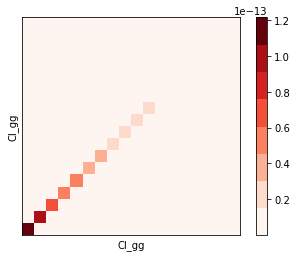

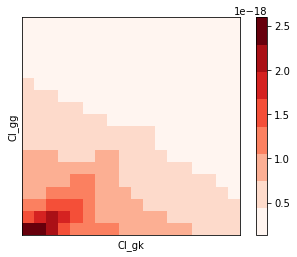

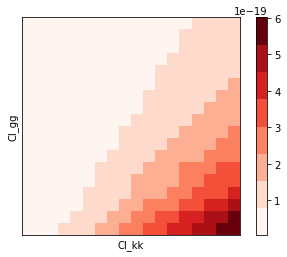

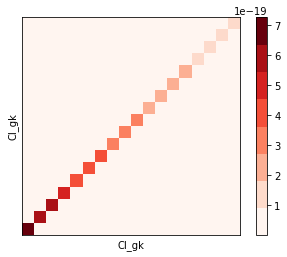

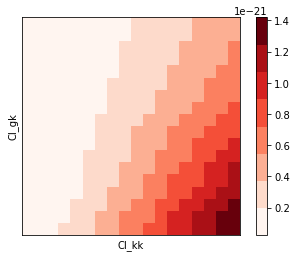

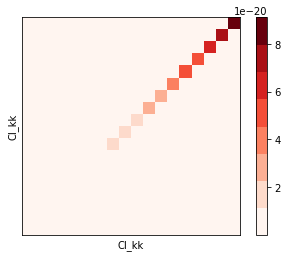

In [42]:
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gk[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        



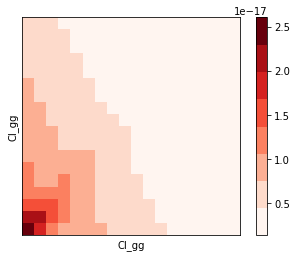

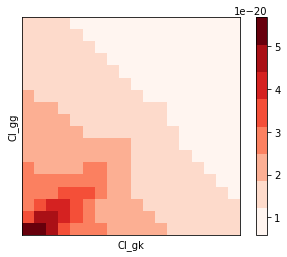

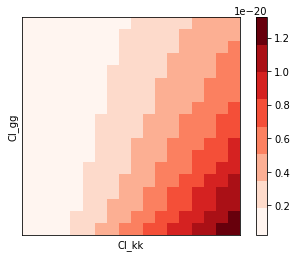

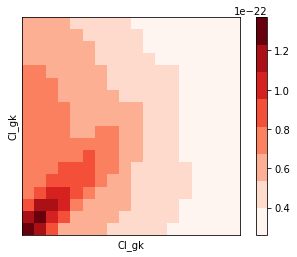

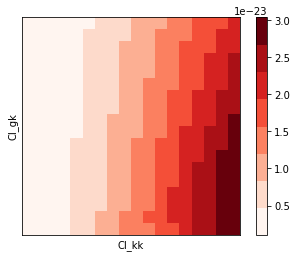

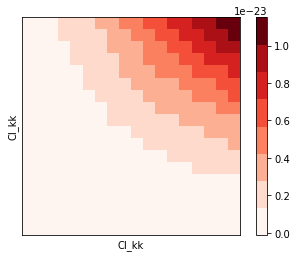

In [43]:
# Low_ell with #high ell
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        



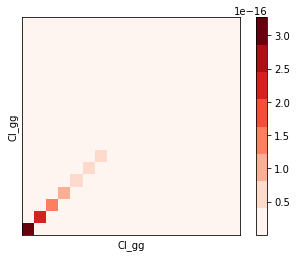

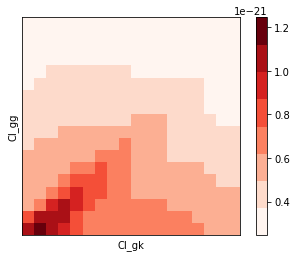

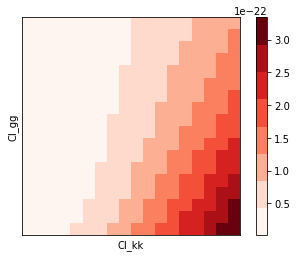

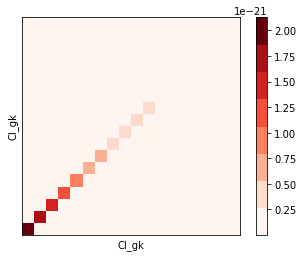

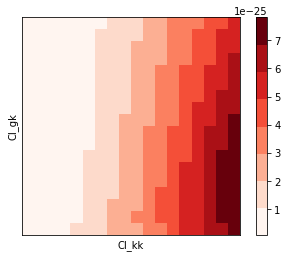

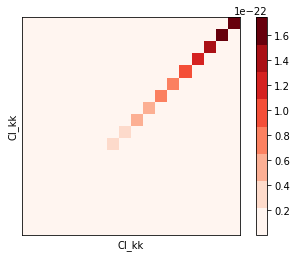

In [44]:
# high_ell with #high ell
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        



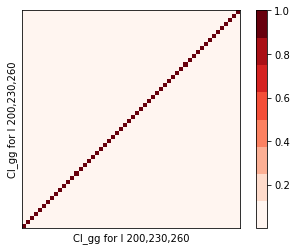

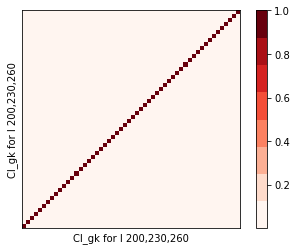

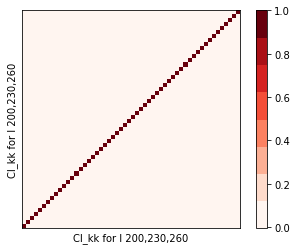

In [45]:
#full normalized matrices

norm_matrix_gg_gg = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))
norm_matrix_gk_gg = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))
norm_matrix_kk_gg = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))

norm_matrix_gk_gk = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))
norm_matrix_kk_gk = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))

norm_matrix_kk_kk = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))

#First let's calculate the similar probes
for i in range(n_ell*Num_z_bins):
    for j in range (i, n_ell*Num_z_bins):
        norm_matrix_gg_gg[i,j] = matrix_Cl_gg_Cl_gg[i,j]/np.sqrt(matrix_Cl_gg_Cl_gg[i,i]*matrix_Cl_gg_Cl_gg[j,j])
        norm_matrix_gg_gg[j,i] = norm_matrix_gg_gg[i,j]
        norm_matrix_gk_gk[i,j] = matrix_Cl_gk_Cl_gk[i,j]/np.sqrt(matrix_Cl_gk_Cl_gk[i,i]*matrix_Cl_gk_Cl_gk[j,j])
        norm_matrix_gk_gk[j,i] = norm_matrix_gk_gk[i,j]        
        norm_matrix_kk_kk[i,j] = matrix_Cl_kk_Cl_kk[i,j]/np.sqrt(matrix_Cl_kk_Cl_kk[i,i]*matrix_Cl_kk_Cl_kk[j,j])
        norm_matrix_kk_kk[j,i] = norm_matrix_kk_kk[i,j]
        
plt.imshow(np.rot90(norm_matrix_gg_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg for l 200,230,260")
plt.ylabel("Cl_gg for l 200,230,260")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(norm_matrix_gk_gk), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk for l 200,230,260")
plt.ylabel("Cl_gk for l 200,230,260")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(norm_matrix_kk_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk for l 200,230,260")
plt.ylabel("Cl_kk for l 200,230,260")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 



In [46]:
matrix_Cl_gg_Cl_gg = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))
matrix_Cl_gk_Cl_gk = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))
matrix_Cl_kk_Cl_kk = np.zeros((Num_z_bins*n_ell, Num_z_bins*n_ell))

#First let's do the similar probes covariances, WITHOUT GAUSSIAN PART, JUST SSC:
for row in range (Num_z_bins*n_ell):
    for column in range (row, Num_z_bins*n_ell):
        print("row " + str(row) + "; column " + str(column))
        matrix_Cl_gg_Cl_gg[row,column] = COV_Cl_gg_Cl_gg(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, False)
        matrix_Cl_gg_Cl_gg[column,row] = matrix_Cl_gg_Cl_gg[row,column]
        matrix_Cl_gk_Cl_gk[row,column] = COV_Cl_gk_Cl_gk(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, False)
        matrix_Cl_gk_Cl_gk[column,row] = matrix_Cl_gk_Cl_gk[row,column]
        matrix_Cl_kk_Cl_kk[row,column] = COV_Cl_kk_Cl_kk(np.mod(row,Num_z_bins), np.mod(row,Num_z_bins), row//Num_z_bins, np.mod(column,Num_z_bins), np.mod(column,Num_z_bins), column//Num_z_bins, False)
        matrix_Cl_kk_Cl_kk[column,row] = matrix_Cl_kk_Cl_kk[row,column]
        

        


row 0; column 0
row 0; column 1
row 0; column 2
row 0; column 3
row 0; column 4
row 0; column 5
row 0; column 6
row 0; column 7
row 0; column 8
row 0; column 9
row 0; column 10
row 0; column 11
row 0; column 12
row 0; column 13
row 0; column 14
row 0; column 15
row 0; column 16
row 0; column 17
row 0; column 18
row 0; column 19
row 0; column 20
row 0; column 21
row 0; column 22
row 0; column 23
row 0; column 24
row 0; column 25
row 0; column 26
row 0; column 27
row 0; column 28
row 0; column 29
row 0; column 30
row 0; column 31
row 0; column 32
row 0; column 33
row 0; column 34
row 0; column 35
row 0; column 36
row 0; column 37
row 0; column 38
row 0; column 39
row 0; column 40
row 0; column 41
row 0; column 42
row 0; column 43
row 0; column 44
row 0; column 45
row 0; column 46
row 0; column 47
row 0; column 48
row 0; column 49
row 0; column 50
row 0; column 51
row 0; column 52
row 0; column 53
row 1; column 1
row 1; column 2
row 1; column 3
row 1; column 4
row 1; column 5
row 1; colum

row 9; column 45
row 9; column 46
row 9; column 47
row 9; column 48
row 9; column 49
row 9; column 50
row 9; column 51
row 9; column 52
row 9; column 53
row 10; column 10
row 10; column 11
row 10; column 12
row 10; column 13
row 10; column 14
row 10; column 15
row 10; column 16
row 10; column 17
row 10; column 18
row 10; column 19
row 10; column 20
row 10; column 21
row 10; column 22
row 10; column 23
row 10; column 24
row 10; column 25
row 10; column 26
row 10; column 27
row 10; column 28
row 10; column 29
row 10; column 30
row 10; column 31
row 10; column 32
row 10; column 33
row 10; column 34
row 10; column 35
row 10; column 36
row 10; column 37
row 10; column 38
row 10; column 39
row 10; column 40
row 10; column 41
row 10; column 42
row 10; column 43
row 10; column 44
row 10; column 45
row 10; column 46
row 10; column 47
row 10; column 48
row 10; column 49
row 10; column 50
row 10; column 51
row 10; column 52
row 10; column 53
row 11; column 11
row 11; column 12
row 11; column 13
r

row 21; column 39
row 21; column 40
row 21; column 41
row 21; column 42
row 21; column 43
row 21; column 44
row 21; column 45
row 21; column 46
row 21; column 47
row 21; column 48
row 21; column 49
row 21; column 50
row 21; column 51
row 21; column 52
row 21; column 53
row 22; column 22
row 22; column 23
row 22; column 24
row 22; column 25
row 22; column 26
row 22; column 27
row 22; column 28
row 22; column 29
row 22; column 30
row 22; column 31
row 22; column 32
row 22; column 33
row 22; column 34
row 22; column 35
row 22; column 36
row 22; column 37
row 22; column 38
row 22; column 39
row 22; column 40
row 22; column 41
row 22; column 42
row 22; column 43
row 22; column 44
row 22; column 45
row 22; column 46
row 22; column 47
row 22; column 48
row 22; column 49
row 22; column 50
row 22; column 51
row 22; column 52
row 22; column 53
row 23; column 23
row 23; column 24
row 23; column 25
row 23; column 26
row 23; column 27
row 23; column 28
row 23; column 29
row 23; column 30
row 23; co

row 41; column 45
row 41; column 46
row 41; column 47
row 41; column 48
row 41; column 49
row 41; column 50
row 41; column 51
row 41; column 52
row 41; column 53
row 42; column 42
row 42; column 43
row 42; column 44
row 42; column 45
row 42; column 46
row 42; column 47
row 42; column 48
row 42; column 49
row 42; column 50
row 42; column 51
row 42; column 52
row 42; column 53
row 43; column 43
row 43; column 44
row 43; column 45
row 43; column 46
row 43; column 47
row 43; column 48
row 43; column 49
row 43; column 50
row 43; column 51
row 43; column 52
row 43; column 53
row 44; column 44
row 44; column 45
row 44; column 46
row 44; column 47
row 44; column 48
row 44; column 49
row 44; column 50
row 44; column 51
row 44; column 52
row 44; column 53
row 45; column 45
row 45; column 46
row 45; column 47
row 45; column 48
row 45; column 49
row 45; column 50
row 45; column 51
row 45; column 52
row 45; column 53
row 46; column 46
row 46; column 47
row 46; column 48
row 46; column 49
row 46; co

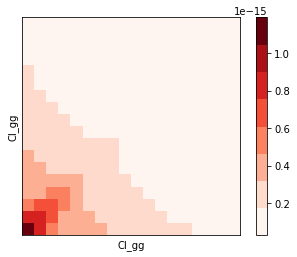

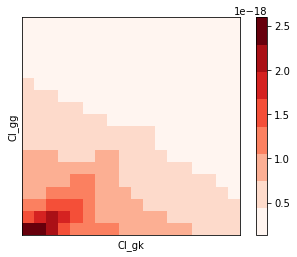

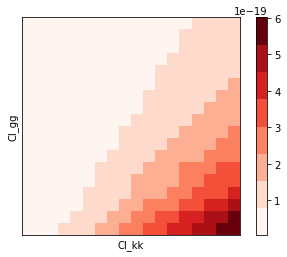

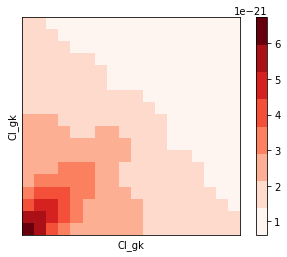

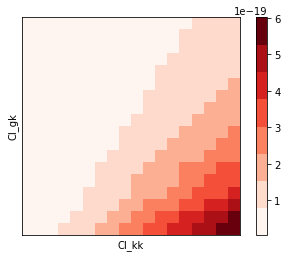

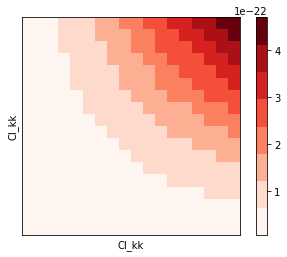

In [47]:
# Low_ell with #Low ell
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 


plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[:18,:18]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show() 


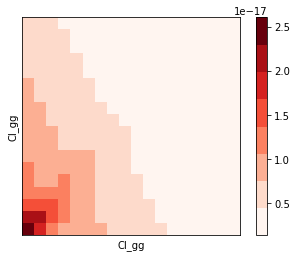

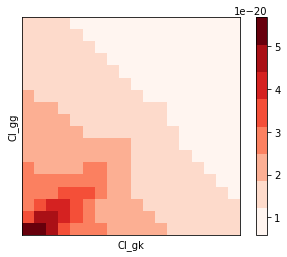

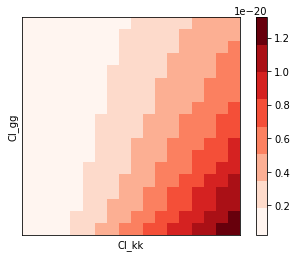

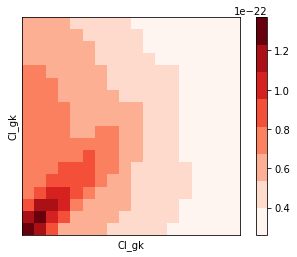

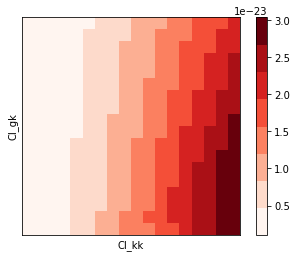

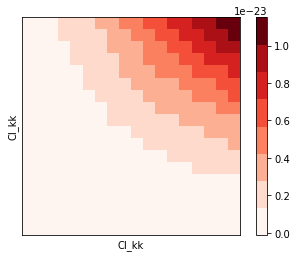

In [48]:
# Low_ell with #high ell
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[:18,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        


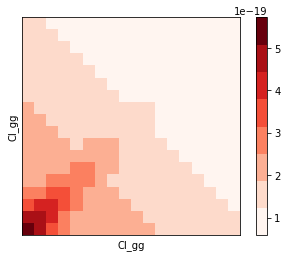

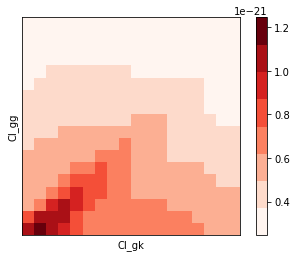

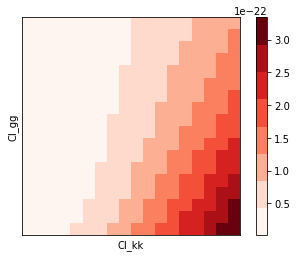

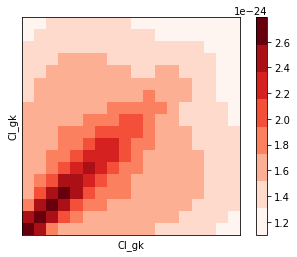

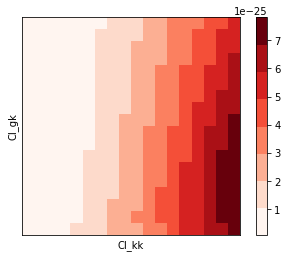

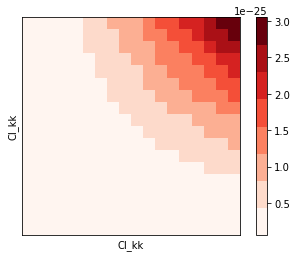

In [49]:
# high_ell with #high ell
plt.imshow(np.rot90(matrix_Cl_gg_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gg[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gg")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_gk_Cl_gk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_gk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_gk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        

plt.imshow(np.rot90(matrix_Cl_kk_Cl_kk[36:,36:]), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk")
plt.ylabel("Cl_kk")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()        


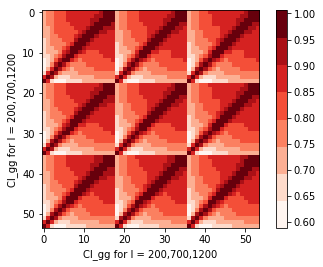

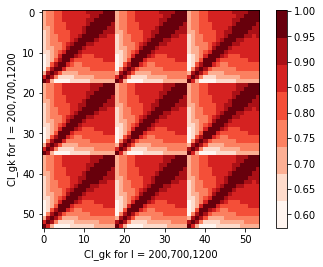

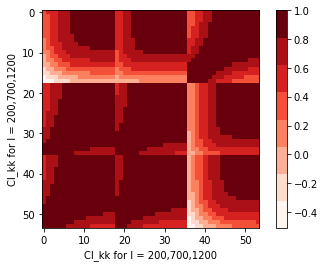

In [51]:
#full normalized matrices_without_gauss

norm_matrix_gg_gg = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))
norm_matrix_gk_gk = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))
norm_matrix_kk_kk = np.zeros((n_ell*Num_z_bins, n_ell*Num_z_bins))

#First let's calculate the similar probes
for i in range(n_ell*Num_z_bins):
    for j in range (i, n_ell*Num_z_bins):
        norm_matrix_gg_gg[i,j] = matrix_Cl_gg_Cl_gg[i,j]/np.sqrt(matrix_Cl_gg_Cl_gg[i,i]*matrix_Cl_gg_Cl_gg[j,j])
        norm_matrix_gg_gg[j,i] = norm_matrix_gg_gg[i,j]
        norm_matrix_gk_gk[i,j] = matrix_Cl_gk_Cl_gk[i,j]/np.sqrt(matrix_Cl_gk_Cl_gk[i,i]*matrix_Cl_gk_Cl_gk[j,j])
        norm_matrix_gk_gk[j,i] = norm_matrix_gk_gk[i,j]        
        norm_matrix_kk_kk[i,j] = matrix_Cl_kk_Cl_kk[i,j]/np.sqrt(matrix_Cl_kk_Cl_kk[i,i]*matrix_Cl_kk_Cl_kk[j,j])
        norm_matrix_kk_kk[j,i] = norm_matrix_kk_kk[i,j]
        
plt.imshow(np.rot90(norm_matrix_gg_gg), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gg for l = 200,700,1200")
plt.ylabel("Cl_gg for l = 200,700,1200")
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(norm_matrix_gk_gk),cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_gk for l = 200,700,1200")
plt.ylabel("Cl_gk for l = 200,700,1200")
plt.colorbar()
plt.show() 

plt.imshow(np.rot90(norm_matrix_kk_kk), cmap=plt.cm.get_cmap('Reds', 8))
plt.xlabel("Cl_kk for l = 200,700,1200")
plt.ylabel("Cl_kk for l = 200,700,1200")
plt.colorbar()
plt.show() 
